In [1]:
#Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm


In [2]:
#Load data
gh_trvlmode_data = pd.read_csv('GroupedDataONS/GenHealth3cat_travelmode 12 cat_custom-filtered-2023-11-09T17_58_40Z.csv')

In [51]:
# Rename columns
gh_trvlmode_data_fin=[]
gh_trvlmode_data_fin = gh_trvlmode_data

new_column_names=list()
new_column_names=[
'la_code'
,'la_name'
,'gh_cat'
,'gh_desc'
,'trvlmode_cat'
,'trvlmode_desc'
,'people_cnt'
]
column_mapping = dict(zip(gh_trvlmode_data.columns, new_column_names))
gh_trvlmode_data_fin.rename(columns=column_mapping, inplace=True)

In [119]:
#Check how many records are there with does not apply value
filtered_df = gh_trvlmode_data_fin[gh_trvlmode_data_fin['gh_desc'] == 'Does not apply']
filtered_df1 = filtered_df[filtered_df['people_cnt'] != 0]
print(filtered_df1)

Empty DataFrame
Columns: [la_code, la_name, gh_cat, gh_desc, trvlmode_cat, trvlmode_desc, people_cnt]
Index: []


In [53]:
# Remove the records with general health does not apply as there are no values for these in people count
gh_trvlmode_data_fin = gh_trvlmode_data_fin[gh_trvlmode_data_fin['gh_desc'] != 'Does not apply']

# Remove the records that fall under Not in employment as it is not applicable for travlemode
gh_trvlmode_data_fin = gh_trvlmode_data_fin[gh_trvlmode_data_fin['trvlmode_desc'] !='Not in employment or aged 15 years and under']

In [54]:
#gh_trvlmode_data_fin['trvlmode_desc'].unique()

array(['Work mainly at or from home',
       'Underground, metro, light rail, tram', 'Train',
       'Bus, minibus or coach', 'Taxi', 'Motorcycle, scooter or moped',
       'Driving a car or van', 'Passenger in a car or van', 'Bicycle',
       'On foot', 'Other method of travel to work'], dtype=object)

In [64]:
gh_trvlmode_data_fin

,la_code,la_name,gh_cat,gh_desc,trvlmode_cat,trvlmode_desc,people_cnt
12,E06000001,Hartlepool,1,Good health,1,Work mainly at or from home,5756
13,E06000001,Hartlepool,1,Good health,2,"Underground, metro, light rail, tram",30
14,E06000001,Hartlepool,1,Good health,3,Train,244
15,E06000001,Hartlepool,1,Good health,4,"Bus, minibus or coach",1007
16,E06000001,Hartlepool,1,Good health,5,Taxi,508
...,...,...,...,...,...,...,...
11874,W06000024,Merthyr Tydfil,2,Not good health,7,Driving a car or van,1671
11875,W06000024,Merthyr Tydfil,2,Not good health,8,Passenger in a car or van,275
11876,W06000024,Merthyr Tydfil,2,Not good health,9,Bicycle,9
11877,W06000024,Merthyr Tydfil,2,Not good health,10,On foot,239


In [122]:
#Perform chi square test for checking association between gh and trvl mode
from scipy.stats import chi2_contingency

# Select relevant columns
data = gh_trvlmode_data_fin[['gh_cat', 'trvlmode_cat', 'people_cnt']]

# Create a contingency table
contingency_table = pd.crosstab(data['gh_cat'], data['trvlmode_cat'], values=data['people_cnt'], aggfunc='sum', margins=True, margins_name='Total')

# Perform chi-square test
chi2, p, _, _ = chi2_contingency(contingency_table)
cresstab=contingency_table

# Number of observations
n = crosstab.sum().sum()

# Number of categories in the first variable
k = crosstab.shape[0]

# Number of categories in the second variable
r = crosstab.shape[1]

# Calculate Cramer's V
cramers_v = np.sqrt(chi2 / (n * min(k-1, r-1)))

print(f"Cramer's V value: {cramers_v}")

# Display results
print(f"Chi-square value: {chi2}")
print(f"P-value: {p}")

# Interpret the results
if p < 0.05:
    print("There is a significant association between health category and travel mode.")
else:
    print("There is no significant association between health category and travel mode.")


Cramer's V value: 0.4038567052784936
Chi-square value: 77059.15413490008
P-value: 0.0
There is a significant association between health category and travel mode.


In [72]:
#create a model using Poisson regression model

import statsmodels.api as sm

# Assuming df is your DataFrame with the provided data
# Select relevant columns
data = gh_trvlmode_data_fin[['gh_cat', 'trvlmode_cat', 'people_cnt']]

# Create dummy variables for the categorical variable trvlmode_cat
data_dummies = pd.get_dummies(data, columns=['trvlmode_cat'], prefix='trvlmode')

# Aggregate data to create a binary outcome variable
data_dummies['gh_cat_binary'] = (data_dummies['gh_cat'] == 1).astype(int)

# Aggregate data by summing people_cnt for each combination
aggregated_data = data_dummies.groupby(['gh_cat_binary', 'trvlmode_1', 'trvlmode_2', 'trvlmode_3', 'trvlmode_4', 'trvlmode_5', 'trvlmode_6', 'trvlmode_7', 'trvlmode_8', 'trvlmode_9', 'trvlmode_10', 'trvlmode_11']).agg({'people_cnt': 'sum'}).reset_index()

# Define independent variables
X = aggregated_data[['trvlmode_1', 'trvlmode_2', 'trvlmode_3', 'trvlmode_4', 'trvlmode_5', 'trvlmode_6', 'trvlmode_7', 'trvlmode_8', 'trvlmode_9', 'trvlmode_10', 'trvlmode_11']]
y = aggregated_data['gh_cat_binary']

# Add an intercept term
X = sm.add_constant(X)

# Fit Poisson regression model with offset
poisson_model = sm.GLM(y, X, family=sm.families.Poisson(), offset=np.log(aggregated_data['people_cnt']))
result = poisson_model.fit()

# Display the summary
print(result.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:          gh_cat_binary   No. Observations:                   22
Model:                            GLM   Df Residuals:                       11
Model Family:                 Poisson   Df Model:                           10
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12.389
Date:                Fri, 17 Nov 2023   Deviance:                       2.7786
Time:                        19:29:01   Pearson chi2:                     1.49
No. Iterations:                     4   Pseudo R-squ. (CS):             0.6424
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -12.5704      0.276    -45.482      

In [74]:
# Coefficients from the Poisson regression model
coefficients = result.params

# Define the predictor variables for a specific category (e.g., gh_cat_binary = 0)
predictor_values = aggregated_data[['trvlmode_1', 'trvlmode_2', 'trvlmode_3', 'trvlmode_4', 'trvlmode_5', 'trvlmode_6', 'trvlmode_7', 'trvlmode_8', 'trvlmode_9', 'trvlmode_10', 'trvlmode_11']].loc[aggregated_data['gh_cat_binary'] == 0].iloc[0]

coefficients = coefficients[:-1] 
# Calculate the log-odds for the specified category
log_odds = np.dot(coefficients, predictor_values)

# Convert log-odds to probability
probability = np.exp(log_odds) / (1 + np.exp(log_odds))

# Display the results
print(f"Probability for gh_cat_binary = 0: {probability:.4f}")


Probability for gh_cat_binary = 0: 0.1199


In [87]:
# Obtain predicted probabilities
predicted_probs = result.predict(X)

# Combine predicted probabilities with the original data
aggregated_data['predicted_probs'] = predicted_probs

# Calculate the probability of reporting "Good health" for each travel mode
prob_good_health_by_mode = aggregated_data.groupby('trvlmode_10')['predicted_probs'].mean().reset_index()

# Display the results
#print(prob_good_health_by_mode)


# Multiply the predicted probabilities by 100 to get percentages
prob_good_health_by_mode['predicted_probs_percent'] = prob_good_health_by_mode['predicted_probs'] * 100

# Display the results
print(prob_good_health_by_mode)


   trvlmode_10  predicted_probs  predicted_probs_percent
0            0     2.385251e-06                 0.000239
1            1     4.731775e-07                 0.000047


In [90]:
predictor_values_cat0 = aggregated_data[['trvlmode_1']].loc[aggregated_data['gh_cat_binary'] == 0].values
predictor_values_cat0

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1]], dtype=uint64)

In [111]:
# Assuming you have a variable named 'coefficients' containing your logistic regression coefficients
a=coefficients[1:].values

coefficients_reshaped = a.reshape(11, 1)

coefficients_reshaped.tolist()

[[-3.405093620128345],
 [-0.5624537697135024],
 [-0.6092008991008795],
 [-1.3943099232567144],
 [0.3619880897493952],
 [0.8041833747738885],
 [-3.7727327127489225],
 [-1.3251918396653446],
 [-0.6814865541139525],
 [-1.9933474503329531],
 [0.007197420765259643]]

In [112]:
predictor_values_cat0.tolist()

[[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [1]]

In [114]:

np.dot(predictor_values_cat0.T, coefficients_reshaped)

array([[0.00719742]])

In [118]:
# Coefficients from the Poisson regression model
coefficients = result.params
a=coefficients[1:].values
coefficients_reshaped = a.reshape(11, 1)
# List of travel modes
travel_modes = ['trvlmode_1', 'trvlmode_2', 'trvlmode_3', 'trvlmode_4', 'trvlmode_5', 'trvlmode_6', 'trvlmode_7', 'trvlmode_8', 'trvlmode_9', 'trvlmode_10', 'trvlmode_11']

# Create an empty DataFrame to store the results
probability_df = pd.DataFrame(columns=['Travel_Mode', 'gh_cat_binary_0', 'gh_cat_binary_1'])

# Iterate through each travel mode
for travel_mode in travel_modes:
    # Select the predictor variable for gh_cat_binary = 0
    predictor_values_cat0 = aggregated_data[[travel_mode]].loc[aggregated_data['gh_cat_binary'] == 0].values
    
    # Calculate the log-odds for gh_cat_binary = 0
    log_odds_cat0 = np.dot(predictor_values_cat0.T, coefficients_reshaped) + coefficients[0]  # Add the intercept term
    
    # Convert log-odds to probability for gh_cat_binary = 0
    probability_cat0 = np.exp(log_odds_cat0) / (1 + np.exp(log_odds_cat0))
    
    # Select the predictor variable for gh_cat_binary = 1
    predictor_values_cat1 = aggregated_data[[travel_mode]].loc[aggregated_data['gh_cat_binary'] == 1].values
    
    # Calculate the log-odds for gh_cat_binary = 1
    log_odds_cat1 = np.dot(predictor_values_cat1.T, coefficients_reshaped) + coefficients[0]  # Add the intercept term
    
    # Convert log-odds to probability for gh_cat_binary = 1
    probability_cat1 = np.exp(log_odds_cat1) / (1 + np.exp(log_odds_cat1))
    
    # Append the results to the DataFrame
    probability_df = probability_df.append({'Travel_Mode': travel_mode, 'gh_cat_binary_0': probability_cat0.item(), 'gh_cat_binary_1': probability_cat1.item()}, ignore_index=True)

# Display the results
print(probability_df)


    Travel_Mode  gh_cat_binary_0  gh_cat_binary_1
0    trvlmode_1     3.498228e-06     3.498228e-06
1    trvlmode_2     4.731772e-07     4.731772e-07
2    trvlmode_3     1.756941e-06     1.756941e-06
3    trvlmode_4     9.229963e-07     9.229963e-07
4    trvlmode_5     7.984483e-08     7.984483e-08
5    trvlmode_6     7.761986e-06     7.761986e-06
6    trvlmode_7     4.988054e-06     4.988054e-06
7    trvlmode_8     8.613554e-07     8.613554e-07
8    trvlmode_9     1.888645e-06     1.888645e-06
9   trvlmode_10     1.979030e-06     1.979030e-06
10  trvlmode_11     1.153215e-07     1.153215e-07


C:\Users\91956\AppData\Local\Temp\ipykernel_28584\3830041324.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  probability_df = probability_df.append({'Travel_Mode': travel_mode, 'gh_cat_binary_0': probability_cat0.item(), 'gh_cat_binary_1': probability_cat1.item()}, ignore_index=True)
C:\Users\91956\AppData\Local\Temp\ipykernel_28584\3830041324.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  probability_df = probability_df.append({'Travel_Mode': travel_mode, 'gh_cat_binary_0': probability_cat0.item(), 'gh_cat_binary_1': probability_cat1.item()}, ignore_index=True)
C:\Users\91956\AppData\Local\Temp\ipykernel_28584\3830041324.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  probability_df = probability_df.append(

In [ ]:
# Select predictor variables
predictor_values_cat0 = aggregated_data[['peoplecnt', travel_mode]].loc[aggregated_data['gh_cat_binary'] == 0].values
predictor_values_cat1 = aggregated_data[['peoplecnt', travel_mode]].loc[aggregated_data['gh_cat_binary'] == 1].values

# Calculate log-odds
log_odds_cat0 = np.dot(predictor_values_cat0.T, coefficients.values) + coefficients[0]
log_odds_cat1 = np.dot(predictor_values_cat1, coefficients.values) + coefficients[0]

# Convert log-odds to probability
probability_cat0 = np.exp(log_odds_cat0) / (1 + np.exp(log_odds_cat0))
probability_cat1 = np.exp(log_odds_cat1) / (1 + np.exp(log_odds_cat1))


In [63]:
aggregated_data

,gh_cat_binary,trvlmode_1,trvlmode_2,trvlmode_3,trvlmode_4,trvlmode_5,trvlmode_6,trvlmode_7,trvlmode_8,trvlmode_9,trvlmode_10,trvlmode_11,people_cnt
0,0,0,0,0,0,0,0,0,0,0,0,1,47257
1,0,0,0,0,0,0,0,0,0,0,1,0,248030
2,0,0,0,0,0,0,0,0,0,1,0,0,47445
3,0,0,0,0,0,0,0,0,1,0,0,0,132854
4,0,0,0,0,0,0,0,1,0,0,0,0,1283513
5,0,0,0,0,0,0,1,0,0,0,0,0,15796
6,0,0,0,0,0,1,0,0,0,0,0,0,36497
7,0,0,0,0,1,0,0,0,0,0,0,0,170232
8,0,0,0,1,0,0,0,0,0,0,0,0,44860
9,0,0,1,0,0,0,0,0,0,0,0,0,39735


In [57]:

array(['Work mainly at or from home',
       'Underground, metro, light rail, tram',
         'Train',
       'Bus, minibus or coach',
         'Taxi',
           'Motorcycle, scooter or moped',
       'Driving a car or van', 
       'Passenger in a car or van', 
       'Bicycle',
       'On foot',
         'Other method of travel to work'], dtype=object)

data_dummies

,gh_cat,people_cnt,trvlmode_1,trvlmode_2,trvlmode_3,trvlmode_4,trvlmode_5,trvlmode_6,trvlmode_7,trvlmode_8,trvlmode_9,trvlmode_10,trvlmode_11,gh_cat_binary
12,1,5756,1,0,0,0,0,0,0,0,0,0,0,1
13,1,30,0,1,0,0,0,0,0,0,0,0,0,1
14,1,244,0,0,1,0,0,0,0,0,0,0,0,1
15,1,1007,0,0,0,1,0,0,0,0,0,0,0,1
16,1,508,0,0,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11874,2,1671,0,0,0,0,0,0,1,0,0,0,0,0
11875,2,275,0,0,0,0,0,0,0,1,0,0,0,0
11876,2,9,0,0,0,0,0,0,0,0,1,0,0,0
11877,2,239,0,0,0,0,0,0,0,0,0,1,0,0


In [9]:
print(gh_trvlmode_data_fin['la_name'].unique())

['Hartlepool' 'Middlesbrough' 'Redcar and Cleveland' 'Stockton-on-Tees'
 'Darlington' 'Halton' 'Warrington' 'Blackburn with Darwen' 'Blackpool'
 'Kingston upon Hull' 'East Riding of Yorkshire' 'North East Lincolnshire'
 'North Lincolnshire' 'York' 'Derby' 'Leicester' 'Rutland' 'Nottingham'
 'Herefordshire' 'Telford and Wrekin' 'Stoke-on-Trent'
 'Bath and North East Somerset' 'Bristol' 'North Somerset'
 'South Gloucestershire' 'Plymouth' 'Torbay' 'Swindon' 'Peterborough'
 'Luton' 'Southend-on-Sea' 'Thurrock' 'Medway' 'Bracknell Forest'
 'West Berkshire' 'Reading' 'Slough' 'Windsor and Maidenhead' 'Wokingham'
 'Milton Keynes' 'Brighton and Hove' 'Portsmouth' 'Southampton'
 'Isle of Wight' 'County Durham' 'Cheshire East'
 'Cheshire West and Chester' 'Shropshire' 'Cornwall' 'Wiltshire' 'Bedford'
 'Central Bedfordshire' 'Northumberland'
 'Bournemouth, Christchurch and Poole' 'Dorset' 'Buckinghamshire'
 'North Northamptonshire' 'West Northamptonshire' 'Cambridge'
 'East Cambridgeshire' 'Fenl

In [11]:
new=gh_trvlmode_data_fin[gh_trvlmode_data_fin['la_name']=='Bristol']

In [12]:
from sklearn.preprocessing import OneHotEncoder

# Create the encoder
encoder = OneHotEncoder()


# Assuming df is your DataFrame
df_encoded = pd.get_dummies(new, columns=['gh_cat', 'trvlmode_cat'], prefix=['gh', 'trvlmodes'])


In [35]:
df_encoded['people_cnt'].sum()

238510

In [17]:
from scipy.stats import pointbiserialr

correlation, p_value = pointbiserialr(df_encoded['gh_1'], df_encoded['trvlmodes_3'])
print(f"Point-Biserial Correlation: {correlation}, p-value: {p_value}")

Point-Biserial Correlation: 1.4407267512020765e-18, p-value: 1.0


In [18]:
column_pattern = 'trvlmodes_'  # Replace with your desired pattern
matching_columns = [col for col in df_encoded.columns if col.startswith(column_pattern)]

In [33]:
df_encoded['trvlmode_desc'].unique()

array(['Work mainly at or from home',
       'Underground, metro, light rail, tram', 'Train',
       'Bus, minibus or coach', 'Taxi', 'Motorcycle, scooter or moped',
       'Driving a car or van', 'Passenger in a car or van', 'Bicycle',
       'On foot', 'Other method of travel to work',
       'Not in employment or aged 15 years and under'], dtype=object)

In [34]:
df_encoded=df_encoded[df_encoded['trvlmode_desc']!='Not in employment or aged 15 years and under']

In [19]:
from scipy.stats import pearsonr
# Select the two columns for which you want to calculate the correlation
column2 = df_encoded['gh_1']
correlation_table=[]
for columnname in matching_columns:
    column1 = df_encoded[columnname]
     # Calculate the correlation coefficient and p-value
    correlation_coefficient, p_value = pearsonr(column1, column2)
    correlation_table.append([columnname,'GH',correlation_coefficient,p_value])

# Create a Pandas DataFrame from the correlation_table
correlation_df = pd.DataFrame(correlation_table, columns=['column1', 'column2', 'correlation_coefficient', 'p_value'])

# Print the results
correlation_df

,column1,column2,correlation_coefficient,p_value
0,trvlmodes_1,GH,1.440727e-18,1.0
1,trvlmodes_2,GH,1.440727e-18,1.0
2,trvlmodes_3,GH,1.440727e-18,1.0
3,trvlmodes_4,GH,1.440727e-18,1.0
4,trvlmodes_5,GH,2.919630e-17,1.0
5,trvlmodes_6,GH,2.919630e-17,1.0
6,trvlmodes_7,GH,2.919630e-17,1.0
7,trvlmodes_8,GH,2.919630e-17,1.0
8,trvlmodes_9,GH,2.919630e-17,1.0
9,trvlmodes_10,GH,2.919630e-17,1.0


In [20]:
# Repeat rows based on 'people_cnt'
df_replicated = df_encoded.loc[df_encoded.index.repeat(df_encoded['people_cnt'])].reset_index(drop=True)


In [21]:
df_replicated.shape[0]

472465

In [45]:
df_replicated.head(10)

,la_code,la_name,gh_desc,trvlmode_desc,people_cnt,gh_1,gh_2,trvlmodes_1,trvlmodes_2,trvlmodes_3,trvlmodes_4,trvlmodes_5,trvlmodes_6,trvlmodes_7,trvlmodes_8,trvlmodes_9,trvlmodes_10,trvlmodes_11,trvlmodes_12
0,E06000001,Hartlepool,Good health,Work mainly at or from home,5756,1,0,1,0,0,0,0,0,0,0,0,0,0,0
1,E06000001,Hartlepool,Good health,Work mainly at or from home,5756,1,0,1,0,0,0,0,0,0,0,0,0,0,0
2,E06000001,Hartlepool,Good health,Work mainly at or from home,5756,1,0,1,0,0,0,0,0,0,0,0,0,0,0
3,E06000001,Hartlepool,Good health,Work mainly at or from home,5756,1,0,1,0,0,0,0,0,0,0,0,0,0,0
4,E06000001,Hartlepool,Good health,Work mainly at or from home,5756,1,0,1,0,0,0,0,0,0,0,0,0,0,0
5,E06000001,Hartlepool,Good health,Work mainly at or from home,5756,1,0,1,0,0,0,0,0,0,0,0,0,0,0
6,E06000001,Hartlepool,Good health,Work mainly at or from home,5756,1,0,1,0,0,0,0,0,0,0,0,0,0,0
7,E06000001,Hartlepool,Good health,Work mainly at or from home,5756,1,0,1,0,0,0,0,0,0,0,0,0,0,0
8,E06000001,Hartlepool,Good health,Work mainly at or from home,5756,1,0,1,0,0,0,0,0,0,0,0,0,0,0
9,E06000001,Hartlepool,Good health,Work mainly at or from home,5756,1,0,1,0,0,0,0,0,0,0,0,0,0,0


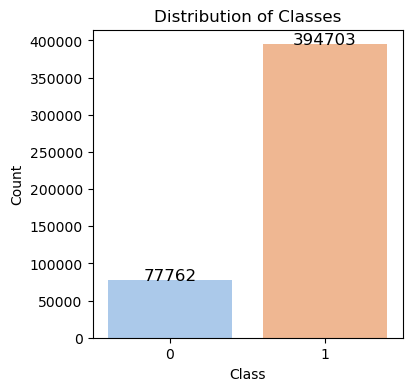

In [22]:
plt.figure(figsize=(4, 4))
ax=sns.countplot(data=df_replicated, x='gh_1', palette='pastel')
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline', fontsize=12)
# Add title and labels
plt.title('Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Count')
# Show the plot
plt.show()

In [24]:
# Calculate the strength of relationship between feature and class variable.
#warnings.filterwarnings("ignore")
from sklearn.feature_selection import chi2
import scipy.stats as stats

data = df_replicated.drop('la_code', axis=1)
data = data.drop('gh_desc',	axis=1)
data = data.drop('la_name', axis=1)
data = data.drop('trvlmode_desc',axis=1)
data = data.drop('people_cnt', axis=1)
data = data.drop('gh_2', axis=1)
results_df = pd.DataFrame(columns=['Feature', 'Chi-Squared', 'p-value'])
# Iterate through each categorical feature
for feature in data.columns:
    if feature != 'gh_1':  # Exclude the class variable itself
        crosstab = pd.crosstab(data[feature], data['gh_1'])
        chi2, p_value, dof, expected = stats.chi2_contingency(crosstab)
        print(f"{feature} chi-squared: {chi2:.3f} (p-value: {p_value:.3f})")
        results_df = results_df.append({'Feature': feature, 'Chi-Squared': chi2, 'p-value': p_value}, ignore_index=True)


trvlmodes_1 chi-squared: 5245.811 (p-value: 0.000)
trvlmodes_2 chi-squared: 4.493 (p-value: 0.034)
trvlmodes_3 chi-squared: 78.324 (p-value: 0.000)


C:\Users\91956\AppData\Local\Temp\ipykernel_28584\3441566256.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Feature': feature, 'Chi-Squared': chi2, 'p-value': p_value}, ignore_index=True)
C:\Users\91956\AppData\Local\Temp\ipykernel_28584\3441566256.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Feature': feature, 'Chi-Squared': chi2, 'p-value': p_value}, ignore_index=True)
C:\Users\91956\AppData\Local\Temp\ipykernel_28584\3441566256.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Feature': feature, 'Chi-Squared': chi2, 'p-value': p_value}, ignore_index=True)


trvlmodes_4 chi-squared: 70.397 (p-value: 0.000)
trvlmodes_5 chi-squared: 0.476 (p-value: 0.490)
trvlmodes_6 chi-squared: 8.247 (p-value: 0.004)


C:\Users\91956\AppData\Local\Temp\ipykernel_28584\3441566256.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Feature': feature, 'Chi-Squared': chi2, 'p-value': p_value}, ignore_index=True)
C:\Users\91956\AppData\Local\Temp\ipykernel_28584\3441566256.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Feature': feature, 'Chi-Squared': chi2, 'p-value': p_value}, ignore_index=True)
C:\Users\91956\AppData\Local\Temp\ipykernel_28584\3441566256.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Feature': feature, 'Chi-Squared': chi2, 'p-value': p_value}, ignore_index=True)


trvlmodes_7 chi-squared: 2115.732 (p-value: 0.000)
trvlmodes_8 chi-squared: 50.469 (p-value: 0.000)
trvlmodes_9 chi-squared: 927.519 (p-value: 0.000)


C:\Users\91956\AppData\Local\Temp\ipykernel_28584\3441566256.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Feature': feature, 'Chi-Squared': chi2, 'p-value': p_value}, ignore_index=True)
C:\Users\91956\AppData\Local\Temp\ipykernel_28584\3441566256.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Feature': feature, 'Chi-Squared': chi2, 'p-value': p_value}, ignore_index=True)
C:\Users\91956\AppData\Local\Temp\ipykernel_28584\3441566256.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Feature': feature, 'Chi-Squared': chi2, 'p-value': p_value}, ignore_index=True)


trvlmodes_10 chi-squared: 707.979 (p-value: 0.000)
trvlmodes_11 chi-squared: 0.635 (p-value: 0.426)
trvlmodes_12 chi-squared: 14327.241 (p-value: 0.000)


C:\Users\91956\AppData\Local\Temp\ipykernel_28584\3441566256.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Feature': feature, 'Chi-Squared': chi2, 'p-value': p_value}, ignore_index=True)
C:\Users\91956\AppData\Local\Temp\ipykernel_28584\3441566256.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Feature': feature, 'Chi-Squared': chi2, 'p-value': p_value}, ignore_index=True)
C:\Users\91956\AppData\Local\Temp\ipykernel_28584\3441566256.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Feature': feature, 'Chi-Squared': chi2, 'p-value': p_value}, ignore_index=True)


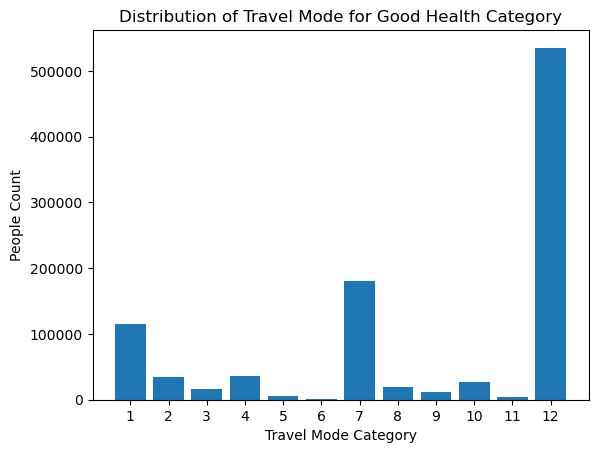

In [25]:
import matplotlib.pyplot as plt

plt.bar(gh_trvlmode_data_fin['trvlmode_cat'].astype(str), gh_trvlmode_data_fin['people_cnt'])
plt.xlabel('Travel Mode Category')
plt.ylabel('People Count')
plt.title('Distribution of Travel Mode for Good Health Category')
plt.show()

In [28]:
data

,gh_1,trvlmodes_1,trvlmodes_2,trvlmodes_3,trvlmodes_4,trvlmodes_5,trvlmodes_6,trvlmodes_7,trvlmodes_8,trvlmodes_9,trvlmodes_10,trvlmodes_11,trvlmodes_12,intercept
0,1,1,0,0,0,0,0,0,0,0,0,0,0,1
1,1,1,0,0,0,0,0,0,0,0,0,0,0,1
2,1,1,0,0,0,0,0,0,0,0,0,0,0,1
3,1,1,0,0,0,0,0,0,0,0,0,0,0,1
4,1,1,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
472460,0,0,0,0,0,0,0,0,0,0,0,0,1,1
472461,0,0,0,0,0,0,0,0,0,0,0,0,1,1
472462,0,0,0,0,0,0,0,0,0,0,0,0,1,1
472463,0,0,0,0,0,0,0,0,0,0,0,0,1,1


In [30]:


# Assuming df is your DataFrame
# Add an intercept term to the predictor variable
#data['intercept'] = 1

# Define predictor and response variables
X = data[[ 'trvlmodes_1','trvlmodes_2','trvlmodes_3','trvlmodes_4','trvlmodes_5','trvlmodes_6','trvlmodes_7','trvlmodes_8','trvlmodes_9','trvlmodes_10','trvlmodes_11','trvlmodes_12']]
y = data['gh_1']

# Fit logistic regression model
logit_model = sm.Logit(y, X)
result = logit_model.fit()

# Display the summary
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.147623
         Iterations 7


c:\Users\91956\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


                           Logit Regression Results                           
Dep. Variable:                   gh_1   No. Observations:               472465
Model:                          Logit   Df Residuals:                   472453
Method:                           MLE   Df Model:                           11
Date:                Wed, 15 Nov 2023   Pseudo R-squ.:                     inf
Time:                        13:45:05   Log-Likelihood:                -69747.
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
trvlmodes_1      2.3745      0.012    201.033      0.000       2.351       2.398
trvlmodes_2      2.3514      0.331      7.105      0.000       1.703       3.000
trvlmodes_3      2.3939      0.089     26.92

c:\Users\91956\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
c:\Users\91956\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:3511: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull


In [29]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assuming df is your DataFrame
# Add an intercept term to the predictor variable
data['intercept'] = 1

# Define predictor and response variables
X = data[['intercept', 'trvlmodes_1', 'trvlmodes_2', 'trvlmodes_3', 'trvlmodes_4', 'trvlmodes_5', 'trvlmodes_6', 'trvlmodes_7', 'trvlmodes_8', 'trvlmodes_9', 'trvlmodes_10', 'trvlmodes_11', 'trvlmodes_12']]
y = data['gh_1']

# Check for multicollinearity
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

# Standardize numeric variables (optional)
# X[['numeric_var1', 'numeric_var2']] = (X[['numeric_var1', 'numeric_var2']] - X[['numeric_var1', 'numeric_var2']].mean()) / X[['numeric_var1', 'numeric_var2']].std()

# Fit logistic regression model with increased maxiter
#logit_model = sm.Logit(y, X, maxiter=1000)
#result = logit_model.fit()

# Display the summary
#print(result.summary())


c:\Users\91956\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
c:\Users\91956\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


        Variable  VIF
0      intercept  0.0
1    trvlmodes_1  inf
2    trvlmodes_2  inf
3    trvlmodes_3  inf
4    trvlmodes_4  inf
5    trvlmodes_5  inf
6    trvlmodes_6  inf
7    trvlmodes_7  inf
8    trvlmodes_8  inf
9    trvlmodes_9  inf
10  trvlmodes_10  inf
11  trvlmodes_11  inf
12  trvlmodes_12  inf


In [61]:
# Get coefficients
beta_0, beta_1 = result.params[0], result.params[1]

# Define the logistic function
def logistic_function(x):
    return 1 / (1 + (2.71828 ** (-x)))

# Calculate probabilities for different values of trvlmodes_1
prob_trvlmodes_1_0 = logistic_function(beta_0)
prob_trvlmodes_1_1 = logistic_function(beta_0 + beta_1)

# Print probabilities
print(f"Probability of gh_1=1 when trvlmodes_11=0: {prob_trvlmodes_1_0:.3f}")
print(f"Probability of gh_1=1 when trvlmodes_11=1: {prob_trvlmodes_1_1:.3f}")


Probability of gh_1=1 when trvlmodes_1=0: 0.805
Probability of gh_1=1 when trvlmodes_1=1: 0.908
